# Momentum distributions

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ May 30, 2023

Plots momentum distributions focusing on scale and scheme dependence.
Single-nucleon and pair momentum distributions are calculated using SRG-evolved momentum projection operators with low-resolution nuclear wavefunctions approximated as a single Slater determinant of Woods-Saxon single-particle orbitals. 

_Last update:_ May 31, 2023

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Imports from scripts
from scripts.figures import (
    label_kvnn, label_lambda, label_nucleus, set_rc_parameters
)
from scripts.tools import replace_periods

from test_momentum_distribution_script_v5 import load_momentum_distribution

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/momentum_distributions/'
vmc_directory = '../data/vmc/momentum_distributions/'

## Single-nucleon momentum distributions

In [5]:
def single_nucleon_momentum_distribution(
        nucleus_name, nucleon, kvnn, lamb, error_bars=False, x_limits=(0.0,6.0),
        y_limits=(9e-6,1e3), y_scale='log', show_vmc=False, save=False
):
    """Plot a single-nucleon momentum distribution with several built-in
    options.
    """
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        
    # Compare to VMC calculation?
    if show_vmc:
        
        file_name = f"{nucleus_name}_single_nucleon.txt"
        data = np.loadtxt(vmc_directory + file_name)
        q_array_vmc = data[:,0]
        n_array_vmc = data[:,1]
        n_errors_vmc = data[:,2]
        
        if y_scale == 'linear':
            
            ax.errorbar(
                q_array_vmc, n_array_vmc * q_array_vmc **2 , yerr=n_errors_vmc,
                color='black', label='VMC', linestyle='', marker='.', zorder=3
            )
            
        else:
            
            ax.errorbar(
                q_array_vmc, n_array_vmc, yerr=n_errors_vmc, color='black',
                label='VMC', linestyle='', marker='.', zorder=3
            )

    # Load data from file
    q_array, q_weights, n_array, n_errors, n_ipm_array, _, _, _, _ = (
        load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
    )
    
    # Multiply by factor (2\pi)^3 to compare to VMC data
    n_array *= (2*np.pi) ** 3
    n_errors *= (2*np.pi) ** 3
    n_ipm_array *= (2*np.pi) ** 3

    # Add to plot
    if y_scale == 'linear':
        
        if error_bars:
            
            ax.errorbar(
                q_array, n_array * q_array ** 2, yerr=n_errors, label='SRG',
                linestyle='solid', linewidth=2.0, zorder=2
            )
    
        else:
            
            ax.plot(q_array, n_array * q_array ** 2, label='SRG', linewidth=2.0,
                    zorder=2)
            
        ax.plot(q_array, n_ipm_array * q_array ** 2, label='IPM',
                linestyle='dotted', linewidth=2.0, zorder=1)

    else:
        
        if error_bars:
            
            ax.errorbar(
                q_array, n_array, yerr=n_errors, label='SRG', linestyle='solid',
                linewidth=2.0, zorder=2
            )
    
        else:
            
            ax.plot(q_array, n_array, label='SRG', linewidth=2.0, zorder=2)
            
        ax.plot(q_array, n_ipm_array, label='IPM', linestyle='dotted',
                linewidth=2.0, zorder=1)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear' and nucleon == 'proton':
        ylabel = r"$q^2 n_{p}(q)$ [fm]"
    elif y_scale == 'linear' and nucleon == 'neutron':
        ylabel = r"$q^2 n_{n}(q)$ [fm]"
    elif y_scale == 'log' and nucleon == 'proton':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    elif y_scale == 'log' and nucleon == 'neutron':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    # Save?
    if save:
        file_name = replace_periods(
            f"{nucleus_name}_{nucleon}_momentum_distribution_kvnn_{kvnn}"
            f"_lamb_{lamb}_{y_scale}_scale"
        )
        f.savefig(figures_directory + file_name + '.png')

In [6]:
def single_nucleon_momentum_distribution_contributions(
        nucleus_name, nucleon, kvnn, lamb, x_limits=(0.0,6.0),
        y_limits=(9e-6,1e3), print_normalization=False, save=False
):
    """Plots momentum distributions showing I, \delta U + \delta U^\dagger, and
    \delta U \delta U^\dagger contributions.
    """
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    # Load data from file
    (q_array, q_weights, n_array, _, n_I_array, n_delU_array, _, n_delU2_array,
     _) = load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
    
    # Multiply by factor (2\pi)^3
    n_array *= (2*np.pi) ** 3
    n_I_array *= (2*np.pi) ** 3
    n_delU_array *= (2*np.pi) ** 3
    n_delU2_array *= (2*np.pi) ** 3

    # Add to plot
    ax.semilogy(q_array, n_I_array, color='blue', label='I', linestyle='dotted',
                linewidth=2.0, zorder=2)
    ax.semilogy(q_array, n_array, color='black', label='Total', linewidth=2.0,
                zorder=1)
    ax.semilogy(
        q_array, np.abs(n_delU_array), color='green',
        label=r'$|\delta U+\delta U^\dagger|$', linestyle='dashed',
        linewidth=2.0, zorder=3
    )
    ax.semilogy(
        q_array, n_delU2_array, color='red',
        label=r'$\delta U \delta U^\dagger$', linestyle='dashdot',
        linewidth=2.0, zorder=4
    )

    # Print normalization?
    if print_normalization:

        total_norm = (4*np.pi)/(2*np.pi) ** 3 * np.sum(
            q_weights * q_array ** 2 * n_array
        )
        print(f"Total normalization = {total_norm}.")
        
        I_norm = (4*np.pi)/(2*np.pi) ** 3 * np.sum(
            q_weights * q_array ** 2 * n_I_array
        )
        print(f"I normalization = {I_norm}.")
        
        delU_norm = (4*np.pi)/(2*np.pi) ** 3 * np.sum(
            q_weights * q_array ** 2 * n_delU_array
        )
        print(f"\delta U + \delta U^\dagger normalization = {delU_norm}.")
        
        delU2_norm = (4*np.pi)/(2*np.pi) ** 3 * np.sum(
            q_weights * q_array ** 2 * n_delU2_array
        )
        print(f"\delta U \delta U^\dagger normalization = {delU2_norm}.")
        
        relative_error = np.abs(delU_norm + delU2_norm) / delU2_norm * 100
        print(f"Relative error = {relative_error}%.")
    
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if nucleon == 'proton':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    elif nucleon == 'neutron':
        ylabel = r"$n_{n}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    # Save?
    if save:
        file_name = replace_periods(
            f"{nucleus_name}_{nucleon}_momentum_distribution_contributions"
            f"_kvnn_{kvnn}_lamb_{lamb}"
        )
        f.savefig(figures_directory + file_name + ".png")

In [21]:
def single_nucleon_momentum_distributions_vary_kvnn(
        nucleus_name, nucleon, kvnns, lamb, x_limits=(0.0,6.0),
        y_limits=(9e-6,1e3), y_scale='log', nucleus_label_location='lower left',
        legend_fontsize=11, save=False
):
    """Plots momentum distributions varying the NN potential."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    
    # Loop over potentials
    for i, kvnn in enumerate(kvnns):
        
        # Load data from file
        (q_array, q_weights, n_array, _, _, _, _, _, _) = (
            load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
        )
    
        # Multiply by factor (2\pi)^3
        n_array *= (2*np.pi) ** 3

        # Add to plot
        if y_scale == 'linear':  # Linear scale
            ax.plot(q_array, n_array * q_array ** 2, label=label_kvnn(kvnn),
                    linewidth=1.5)
        elif y_scale == 'log':  # Log scale
            ax.plot(q_array, n_array, label=label_kvnn(kvnn), linewidth=1.5)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear' and nucleon == 'proton':
        ylabel = r"$q^2 n_{p}(q)$ [fm]"
    elif y_scale == 'linear' and nucleon == 'neutron':
        ylabel = r"$q^2 n_{n}(q)$ [fm]"
    elif y_scale == 'log' and nucleon == 'proton':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    elif y_scale == 'log' and nucleon == 'neutron':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=legend_fontsize, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc=nucleus_label_location,
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    # Save?
    if save:
        file_name = f"{nucleus_name}_{nucleon}_momentum_distributions_kvnns"
        for kvnn in kvnns:
            file_name += f"_{kvnn}"
        file_name += f"_lamb_{lamb}_{y_scale}_scale"
        file_name = replace_periods(file_name)
        f.savefig(figures_directory + file_name + ".png")

In [8]:
def single_nucleon_momentum_distributions_vary_lambda(
        nucleus_name, nucleon, kvnn, lambdas, x_limits=(0.0,6.0),
        y_limits=(9e-6,1e3), y_scale='log', nucleus_label_location='lower left',
        legend_fontsize=11, save=False
):
    """Plots momentum distributions varying the SRG flow parameter \lambda."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    
    # Loop over \lambda
    for i, lamb in enumerate(lambdas):
        
        # Load data from file
        (q_array, q_weights, n_array, _, n_ipm_array, _, _, _, _) = (
            load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
        )
    
        # Multiply by factor (2\pi)^3
        n_array *= (2*np.pi) ** 3
        
        # Plot the IPM (\lambda=\infinity) result once
        if i == 0:
            n_ipm_array *= (2*np.pi) ** 3
            
            if y_scale == 'linear':  # Linear scale
                
                ax.plot(
                    q_array, n_ipm_array * q_array ** 2,
                    label=label_lambda(np.inf), color='black',
                    linestyle='dotted', linewidth=1.5
                )
            
            elif y_scale == 'log':  # Log scale
                
                ax.plot(q_array, n_ipm_array, label=label_lambda(np.inf),
                        color='black', linestyle='dotted', linewidth=1.5)

        # Add to plot
        if y_scale == 'linear':
            
            ax.plot(q_array, n_array * q_array ** 2, alpha=(i+1)/len(lambdas),
                    color='red', label=label_lambda(lamb), linewidth=1.5)
            
        elif y_scale == 'log':
            
            ax.plot(q_array, n_array, alpha=(i+1)/len(lambdas), color='red',
                    label=label_lambda(lamb), linewidth=1.5)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear' and nucleon == 'proton':
        ylabel = r"$q^2 n_{p}(q)$ [fm]"
    elif y_scale == 'linear' and nucleon == 'neutron':
        ylabel = r"$q^2 n_{n}(q)$ [fm]"
    elif y_scale == 'log' and nucleon == 'proton':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    elif y_scale == 'log' and nucleon == 'neutron':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=legend_fontsize, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc=nucleus_label_location,
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = (f"{nucleus_name}_{nucleon}_momentum_distributions_kvnn"
                     f"_{kvnn}_lambdas")
        for lamb in lambdas:
            file_name += f"_{lamb}"
        file_name += f"_{y_scale}_scale"
        file_name = replace_periods(file_name)
        f.savefig(figures_directory + file_name + ".png")

### Proton momentum distributions for several nuclei

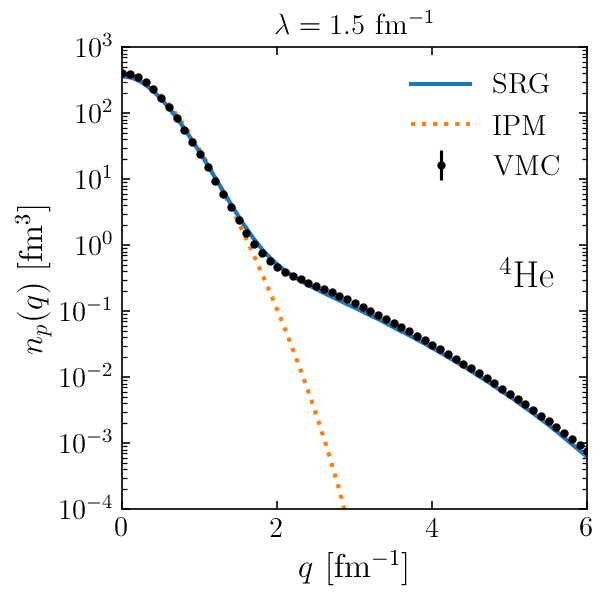

In [9]:
single_nucleon_momentum_distribution(
    'He4', 'proton', 6, 1.5, y_limits=(1e-4, 1e3), y_scale='log', show_vmc=True,
    save=True
)

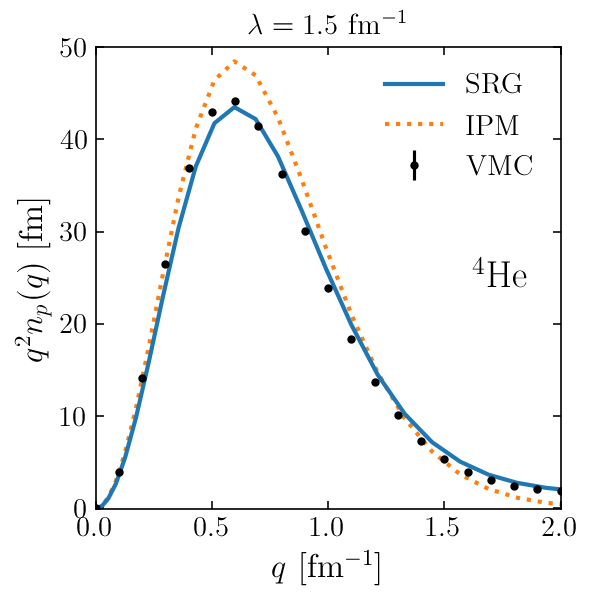

In [10]:
single_nucleon_momentum_distribution(
    'He4', 'proton', 6, 1.5, x_limits=(0.0, 2.0), y_limits=(-0.1, 50),
    y_scale='linear', show_vmc=True, save=True
)

Total normalization = 2.0016116309317487.
I normalization = 2.0019786275044362.
\delta U + \delta U^\dagger normalization = -0.16519666185794554.
\delta U \delta U^\dagger normalization = 0.16482966528525805.
Relative error = 0.22265201597804393%.


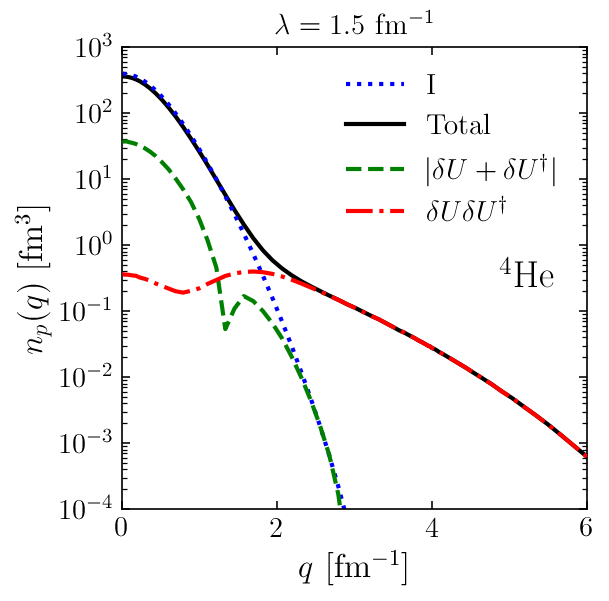

In [11]:
single_nucleon_momentum_distribution_contributions(
    'He4', 'proton', 6, 1.5, y_limits=(1e-4, 1e3), print_normalization=True,
    save=True
)

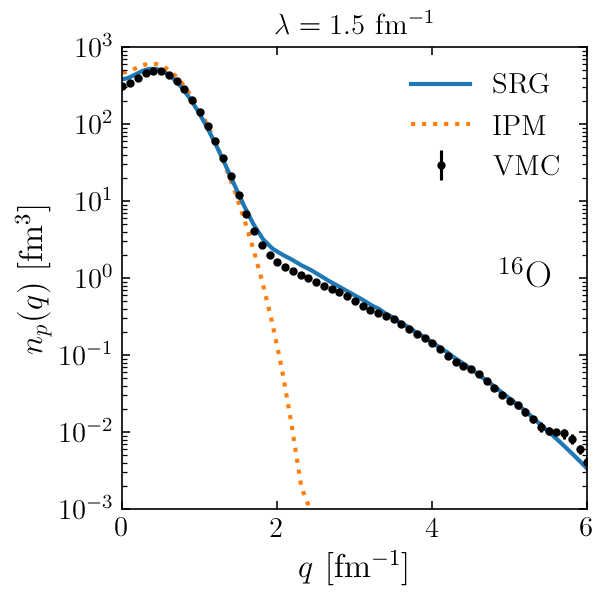

In [12]:
single_nucleon_momentum_distribution(
    'O16', 'proton', 6, 1.5, y_limits=(1e-3, 1e3), y_scale='log', show_vmc=True,
    save=True
)

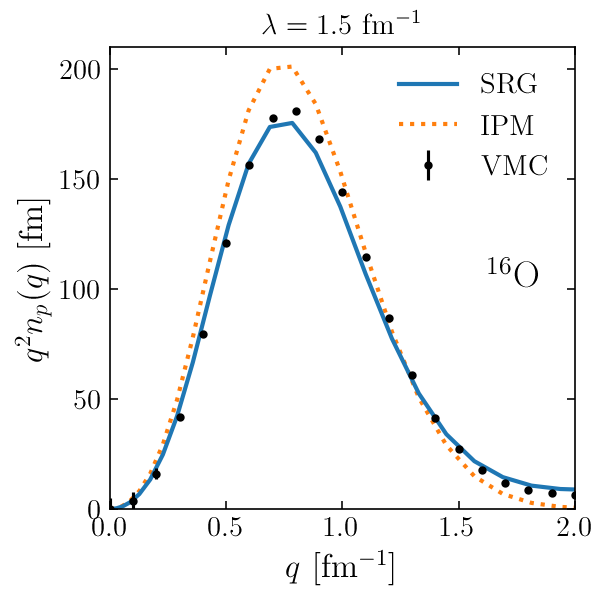

In [13]:
single_nucleon_momentum_distribution(
    'O16', 'proton', 6, 1.5, x_limits=(0.0, 2.0), y_limits=(-0.1, 210.0),
    y_scale='linear', show_vmc=True, save=True
)

Total normalization = 7.997714517444181.
I normalization = 7.999071366053643.
\delta U + \delta U^\dagger normalization = -0.9111212635836012.
\delta U \delta U^\dagger normalization = 0.909764414974138.
Relative error = 0.14914285359269086%.


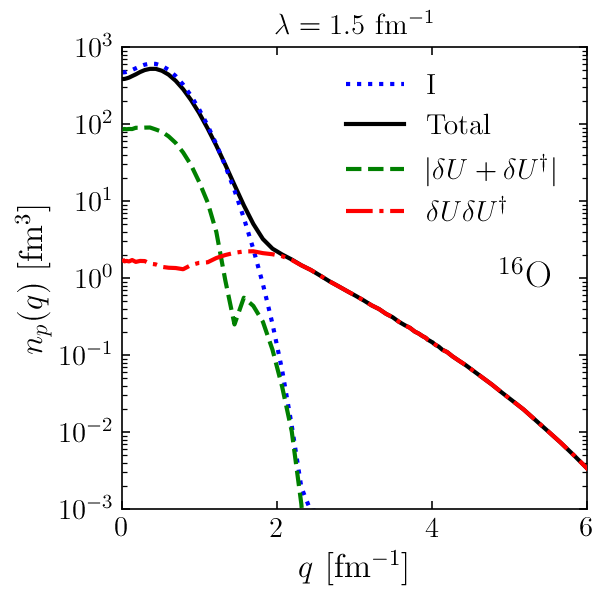

In [14]:
single_nucleon_momentum_distribution_contributions(
    'O16', 'proton', 6, 1.5, y_limits=(1e-3, 1e3), print_normalization=True,
    save=True
)

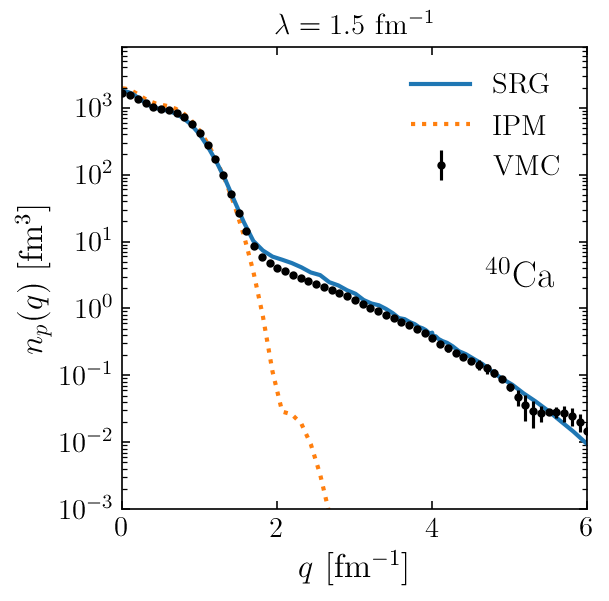

In [15]:
single_nucleon_momentum_distribution(
    'Ca40', 'proton', 6, 1.5, y_limits=(1e-3, 8e3), y_scale='log',
    show_vmc=True, save=True
)

Total normalization = 19.940357548606386.
I normalization = 19.978021511633447.
\delta U + \delta U^\dagger normalization = -2.587797252542885.
\delta U \delta U^\dagger normalization = 2.550133289515821.
Relative error = 1.4769409576318708%.


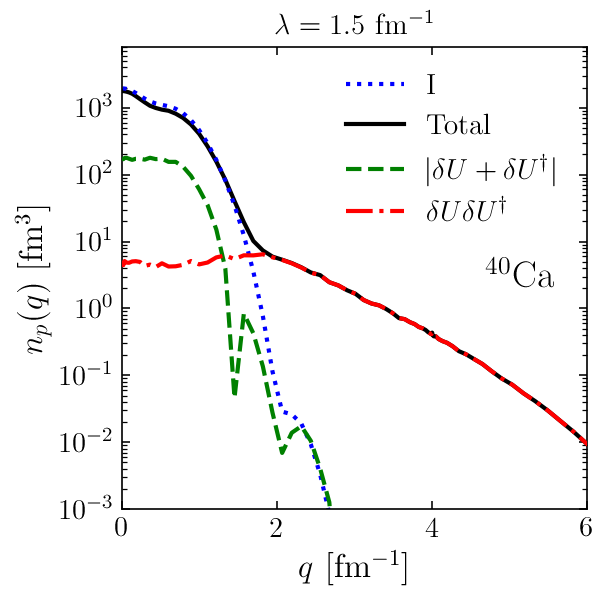

In [16]:
single_nucleon_momentum_distribution_contributions(
    'Ca40', 'proton', 6, 1.5, y_limits=(1e-3, 8e3), print_normalization=True,
    save=True
)

### Comparing different interactions

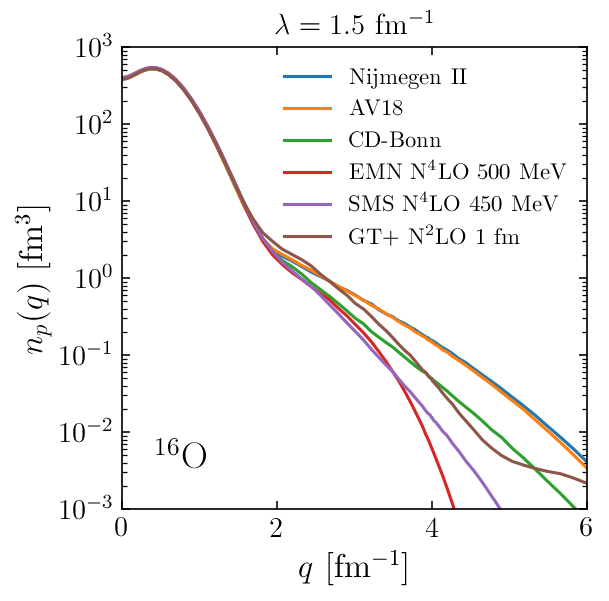

In [22]:
single_nucleon_momentum_distributions_vary_kvnn(
    'O16', 'proton', (5, 6, 7, 79, 111, 222), 1.5, y_limits=(1e-3,1e3),
    save=True
)

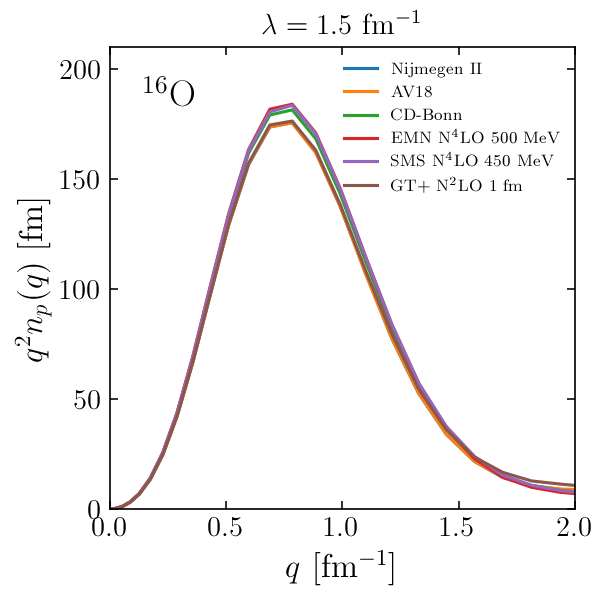

In [18]:
single_nucleon_momentum_distributions_vary_kvnn(
    'O16', 'proton', (5, 6, 7, 79, 111, 222), 1.5, x_limits=(0.0, 2.0),
    y_limits=(-0.1, 210.0), y_scale='linear',
    nucleus_label_location='upper left', legend_fontsize=8, save=True
)

### Comparing different $\lambda$ values

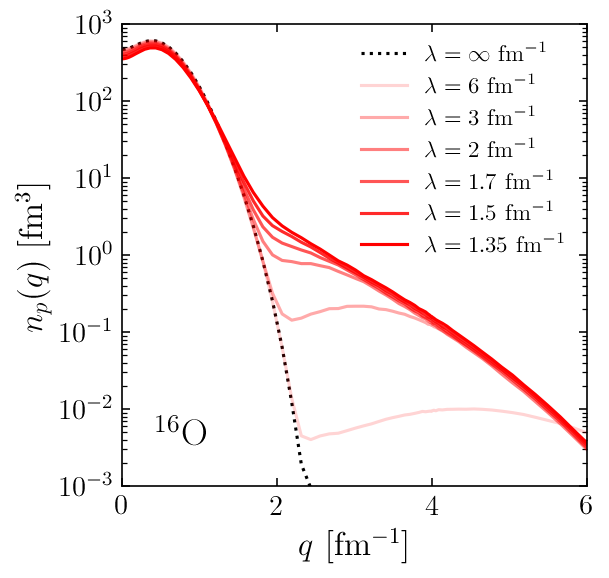

In [19]:
single_nucleon_momentum_distributions_vary_lambda(
    'O16', 'proton', 6, (6.0, 3.0, 2.0, 1.7, 1.5, 1.35), y_limits=(1e-3, 1e3),
    save=True
)

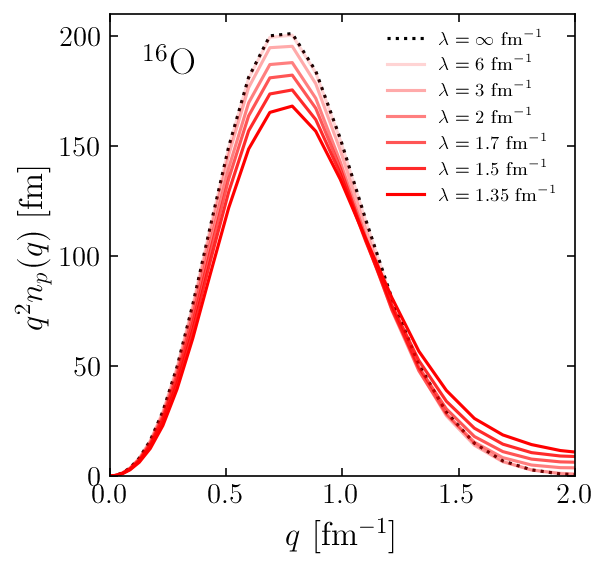

In [23]:
single_nucleon_momentum_distributions_vary_lambda(
    'O16', 'proton', 6, (6.0, 3.0, 2.0, 1.7, 1.5, 1.35), x_limits=(0.0, 2.0),
    y_limits=(-0.1, 210.0), y_scale='linear',
    nucleus_label_location='upper left', legend_fontsize=9, save=True
)

## Pair momentum distributions